# IsNNN400: ClassiFIM and other methods

## Init

In [1]:
import classifim.bench.metric
import classifim.bench.peaks
import classifim.bench.plot_tools
import classifim.datasets
import classifim.huang_pca
import classifim.io
import classifim.ising2d
import classifim.ising2d_w
import classifim.train_logs
import classifim.utils
import concurrent.futures
import datasets
import datetime
import importlib
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import my.utils as mu
import numba
import numpy as np
import os.path
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import re
import sklearn.cluster
import sklearn.decomposition
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
config_device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Cuda is" + ("" if torch.cuda.is_available() else " NOT") + f" available; setting config_device = '{config_device}'.")

# Pick a directory where to save models and FIM:
DATA_DIR0 = classifim.utils.find_data_dir()
SM_NAME = "isnnn_400" # Name of the statistical manifold
DATA_DIR = os.path.join(DATA_DIR0, SM_NAME)

PARAMETER_GRID = [(1/64, 1.0, 64)] * 2
PARAMETER_GRID_EXPANDED = [np.linspace(*g) for g in PARAMETER_GRID]

Cuda is NOT available; setting config_device = 'cpu'.


/home/victor/.local/opt/mambaforge/envs/classifim/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Example: loading dataset

In [3]:
d_train_ds = datasets.load_dataset(
    'fiktor/FIM-Estimation',
    'isnnn_400.seed01', split='train')
d_train = classifim.datasets.dataset_huggingface_to_dict(d_train_ds)

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

In [4]:
d_train

{'seed': 1,
 'lambdas': array([[0.78125 , 0.125   ],
        [0.984375, 0.59375 ],
        [0.234375, 0.84375 ],
        ...,
        [0.21875 , 0.21875 ],
        [0.125   , 0.078125],
        [0.4375  , 0.015625]], dtype=float32),
 'height': 20,
 'width': 20,
 'samples': array([[ 699050,  349525,  699050, ...,  349525,  699050,  349525],
        [ 699050,  349525,  699018, ...,  349525,  699050,  349525],
        [  21854, 1013744,  278847, ...,  784130,  789883, 1004880],
        ...,
        [1048575,       0, 1048575, ...,       0, 1048575,       0],
        [1048575,       0, 1048575, ...,       0, 1048575,       0],
        [ 349525,  349525,  349525, ...,  349525,  349525,  349525]],
       dtype=uint32)}

## ML training

### ClassiFIM

#### Pipeline code

In [21]:
importlib.reload(classifim.io)
importlib.reload(classifim.pipeline)
importlib.reload(classifim.ising2d)

<module 'classifim.ising2d' from '/home/victor/Dropbox (Lidar group)/qc4ml_work/bs_chifc/classifim/src/classifim/ising2d.py'>

In [22]:
MODELS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "models")
FIM_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "fim")
print(f"{MODELS_DIR=}")

def run_pipeline(seed, skip_existing=False, seed1=None, **kwargs):
    t0 = time.time()
    def load_split(split):
        d_split_ds = datasets.load_dataset(
            os.path.expanduser('fiktor/FIM-Estimation'),
            f"isnnn_400.seed{seed:02d}", split=split)
        return classifim.datasets.dataset_huggingface_to_dict(d_split_ds)
    d_train = load_split("train")
    d_test = load_split("test")
    assert d_train["seed"] == seed
    t1 = time.time()
    config = {
        'seed': seed,
        'scalar_keys': ['seed', 'height', 'width'],
        'hold_out_test': False,
        'num_epochs': 200,
        'device': config_device,
        'model_name': 'naive-cnn',
        'weight_decay': 1e-5
    }
    config['model_filename'] = os.path.join(
        MODELS_DIR, f"{config['model_name']}_{config['seed']}.pth")
    config['fim_filename'] = os.path.join(
        FIM_DIR, f"{config['model_name']}_{config['seed']}.npz")
    config['log_filename'] = os.path.join(
        MODELS_DIR, f"{config['model_name']}_{config['seed']}.log.json")
    if skip_existing:
        filenames = [
            config[k]
            for k in ['model_filename', 'fim_filename', 'log_filename']]
        if all(os.path.exists(p) for p in filenames):
            print(f"Skipping {seed=}: all of {filenames} exist.")
            return
    config.update(**kwargs)
    print(f"{datetime.datetime.now()}: {config['model_name']}_{config['seed']}")
    if seed1 is not None:
        prng = classifim.utils.DeterministicPrng((seed, seed1))
    else:
        prng = None
    pipeline = classifim.ising2d.Pipeline(
        config=config,
        d_train=d_train,
        prng=prng)
    cur_log = {"config": pipeline.config}
    t2 = time.time()
    cur_log["train"] = pipeline.train()
    t3 = time.time()
    print(f"{datetime.datetime.now()}: Save")
    pipeline.save_model()
    pipeline.cleanup_after_training()
    pipeline.load_model()
    t4 = time.time()
    if config['hold_out_test']:
        cur_log["test"] = pipeline.test(num_epochs=min(10, pipeline.config["num_epochs"]))
    else:
        cur_log["test"] = pipeline.test(
            d_test=d_test,
            do_transform=True,
            num_epochs=min(10, pipeline.config["num_epochs"]))
    t5 = time.time()
    pipeline.eval_fim()
    pipeline.save_fim()
    t6 = time.time()
    timings = {
        "step0_load": t1 - t0,
        "step1_init": t2 - t1,
        "step2_train": t3 - t2,
        "step3_save": t4 - t3,
        "step4_test": t5 - t4,
        "step5_fim": t6 - t5,
        "total": t6 - t0}
    # Total ClassiFIM time excludes:
    # - loading data (this would need to be done for any method and the time might
    #     depend on caching and network speed)
    # - testing (this is not needed for FIM estimation)
    timings["classifim"] = (
            timings["total"]
            - timings["step4_test"]
            - timings["step0_load"])
    cur_log["timings"] = timings
    print(
        "Timings: "
        + ", ".join(
            f"{key}: {value:.3f}s"
            for key, value in timings.items()))
    with open(config["log_filename"], "w") as f:
        json.dump(cur_log, f)
    print(f"{datetime.datetime.now()}: Done")

MODELS_DIR='/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models'


#### Run pipeline for seed=1

In [176]:
run_pipeline(1)

2024-05-01 14:45:38.490884: naive-cnn_1
2024-05-01 14:45:38.635186: Training started
num_epochs=200: 1:0.6694 2:0.4349 3:0.2425 4:0.1873 5:0.1565 6:0.1368 7:0.1575 8:0.1222 9:0.1248 10:0.1091 11:0.1561 12:0.1052 13:0.1192 14:0.09786 15:0.1028 16:0.1 17:0.09303 18:0.09594 19:0.09629 20:0.09101 21:0.08991 22:0.08831 23:0.0874 24:0.08819 25:0.08453 26:0.08914 27:0.08751 28:0.08754 29:0.08413 30:0.08384 31:0.08287 32:0.08233 33:0.08249 34:0.08273 35:0.0809 36:0.08563 37:0.09731 38:0.08945 39:0.08898 40:0.08753 41:0.08168 42:0.08356 43:0.08517 44:0.08446 45:0.08262 46:0.08302 47:0.07929 48:0.08536 49:0.07975 50:0.0792 51:0.08007 52:0.09676 53:0.09131 54:0.08494 55:0.08007 56:0.08049 57:0.08215 58:0.08073 59:0.07863 60:0.08114 61:0.08473 62:0.08495 63:0.09132 64:0.08164 65:0.07813 66:0.08463 67:0.08291 68:0.07884 69:0.07745 70:0.07932 71:0.07824 72:0.07821 73:0.07868 74:0.0776 75:0.07897 76:0.07808 77:0.08152 78:0.08013 79:0.0808 80:0.07794 81:0.07796 82:0.07723 83:0.07709 84:0.0769 85:0.077

#### Run pipeline for seeds 1..10

In [23]:
%%time
for seed in range(1, 11):
    run_pipeline(seed, skip_existing=False)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

2024-05-12 10:07:05.449481: naive-cnn_1
2024-05-12 10:07:05.778707: Training started
num_epochs=200: 1:0.6695 2:0.4352 3:0.2433 4:0.1872 5:0.1523 6:0.1363 7:0.1256 8:0.1281 9:0.111 10:0.1126 11:0.1179 12:0.09731 13:0.2329 14:0.101 15:0.09848 16:0.09326 17:0.09242 18:0.09233 19:0.0923 20:0.08831 21:0.09102 22:0.08857 23:0.09277 24:0.0859 25:0.08761 26:0.08781 27:0.08175 28:0.0842 29:0.08382 30:0.0855 31:0.0824 32:0.08143 33:0.07996 34:0.08632 35:0.08414 36:0.09563 37:0.09389 38:0.1029 39:0.107 40:0.09662 41:0.0907 42:0.08805 43:0.08628 44:0.09534 45:0.09738 46:0.09049 47:0.09395 48:0.08728 49:0.08906 50:0.08579 51:0.0915 52:0.07867 53:0.08404 54:0.07936 55:0.08072 56:0.09007 57:0.08849 58:0.08536 59:0.08296 60:0.07822 61:0.07876 62:0.07764 63:0.07729 64:0.07754 65:0.07779 66:0.08244 67:0.07825 68:0.0789 69:0.07774 70:0.07824 71:0.0814 72:0.08307 73:0.08029 74:0.07811 75:0.08263 76:0.07737 77:0.07706 78:0.0783 79:0.07776 80:0.07929 81:0.07805 82:0.07736 83:0.07726 84:0.0819 85:0.07994 86

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 10:25:24.200945: naive-cnn_2
2024-05-12 10:25:24.366171: Training started
num_epochs=200: 1:0.666 2:0.4203 3:0.2297 4:0.1691 5:0.1412 6:0.1252 7:0.1153 8:0.1088 9:0.108 10:0.1297 11:0.1062 12:0.0928 13:0.09931 14:0.09922 15:0.09321 16:0.09545 17:0.09317 18:0.09207 19:0.08831 20:0.08569 21:0.08594 22:0.08393 23:0.09131 24:0.08686 25:0.08546 26:0.08819 27:0.08902 28:0.08311 29:0.08189 30:0.08282 31:0.0813 32:0.081 33:0.07997 34:0.09094 35:0.102 36:0.1092 37:0.1047 38:0.08951 39:0.08963 40:0.08423 41:0.08665 42:0.08499 43:0.08728 44:0.08451 45:0.08291 46:0.08535 47:0.0919 48:0.1016 49:0.0846 50:0.08955 51:0.08296 52:0.07878 53:0.07889 54:0.08391 55:0.0846 56:0.08647 57:0.07953 58:0.07846 59:0.0851 60:0.08144 61:0.07972 62:0.07831 63:0.07786 64:0.07786 65:0.07843 66:0.07842 67:0.07865 68:0.07942 69:0.0783 70:0.0842 71:0.07844 72:0.08039 73:0.07885 74:0.07814 75:0.07913 76:0.07749 77:0.07803 78:0.07761 79:0.07738 80:0.08567 81:0.08872 82:0.08763 83:0.08641 84:0.08735 85:0.08163 8

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 10:43:42.148481: naive-cnn_3
2024-05-12 10:43:42.309002: Training started
num_epochs=200: 1:0.6639 2:0.4079 3:0.2329 4:0.1808 5:0.14 6:0.1243 7:0.1155 8:0.1256 9:0.1136 10:0.1013 11:0.1088 12:0.102 13:0.122 14:0.1027 15:0.09531 16:0.113 17:0.09719 18:0.105 19:0.1026 20:0.0993 21:0.09182 22:0.08976 23:0.09246 24:0.0866 25:0.08646 26:0.08543 27:0.0908 28:0.08939 29:0.0948 30:0.1001 31:0.09935 32:0.09717 33:0.09987 34:0.09181 35:0.09521 36:0.0983 37:0.08862 38:0.08916 39:0.09709 40:0.1008 41:0.09548 42:0.09048 43:0.08966 44:0.09825 45:0.08805 46:0.08639 47:0.08307 48:0.09139 49:0.08878 50:0.089 51:0.09767 52:0.0873 53:0.08824 54:0.08606 55:0.09021 56:0.08674 57:0.08041 58:0.08014 59:0.08477 60:0.09042 61:0.08096 62:0.07833 63:0.07732 64:0.07791 65:0.07833 66:0.08137 67:0.07954 68:0.07853 69:0.07825 70:0.0867 71:0.0786 72:0.0788 73:0.08173 74:0.0775 75:0.07787 76:0.07757 77:0.07782 78:0.07732 79:0.07779 80:0.07703 81:0.07758 82:0.08833 83:0.08788 84:0.09145 85:0.09141 86:0.0844 

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 11:02:46.324367: naive-cnn_4
2024-05-12 11:02:46.488547: Training started
num_epochs=200: 1:0.6589 2:0.4067 3:0.2412 4:0.1798 5:0.1398 6:0.1231 7:0.12 8:0.1111 9:0.1083 10:0.1588 11:0.1024 12:0.1233 13:0.1038 14:0.1055 15:0.09716 16:0.1172 17:0.1023 18:0.09317 19:0.09932 20:0.09291 21:0.09094 22:0.08903 23:0.09233 24:0.09943 25:0.09746 26:0.09368 27:0.09533 28:0.08774 29:0.09212 30:0.09005 31:0.08589 32:0.08805 33:0.08846 34:0.09251 35:0.08933 36:0.08468 37:0.08703 38:0.09061 39:0.08397 40:0.09134 41:0.08969 42:0.08792 43:0.08616 44:0.08293 45:0.08755 46:0.08557 47:0.08341 48:0.08779 49:0.0827 50:0.0815 51:0.08617 52:0.08506 53:0.08 54:0.08001 55:0.08036 56:0.08089 57:0.07887 58:0.08604 59:0.07914 60:0.07926 61:0.07938 62:0.07961 63:0.07959 64:0.08815 65:0.09357 66:0.0945 67:0.09014 68:0.08761 69:0.08815 70:0.08755 71:0.0789 72:0.07936 73:0.07903 74:0.07851 75:0.0833 76:0.07887 77:0.08018 78:0.07793 79:0.07809 80:0.07806 81:0.0785 82:0.07758 83:0.07803 84:0.07903 85:0.07759 

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 11:20:42.805561: naive-cnn_5
2024-05-12 11:20:42.971144: Training started
num_epochs=200: 1:0.6661 2:0.4311 3:0.2325 4:0.1836 5:0.1435 6:0.125 7:0.1154 8:0.1383 9:0.1073 10:0.1074 11:0.104 12:0.1037 13:0.09677 14:0.1197 15:0.09191 16:0.09087 17:0.09047 18:0.09357 19:0.09113 20:0.08959 21:0.09062 22:0.0847 23:0.08673 24:0.08788 25:0.1005 26:0.09445 27:0.09498 28:0.09109 29:0.08781 30:0.09212 31:0.08757 32:0.08934 33:0.08856 34:0.08772 35:0.08604 36:0.083 37:0.08866 38:0.0837 39:0.08681 40:0.08689 41:0.08324 42:0.08927 43:0.08618 44:0.08497 45:0.08044 46:0.08107 47:0.08026 48:0.079 49:0.07973 50:0.08012 51:0.07928 52:0.07948 53:0.07953 54:0.08279 55:0.07851 56:0.07885 57:0.07878 58:0.07872 59:0.07841 60:0.07844 61:0.08096 62:0.07777 63:0.08073 64:0.07869 65:0.0781 66:0.07803 67:0.07979 68:0.1003 69:0.08839 70:0.09497 71:0.09933 72:0.09742 73:0.09391 74:0.09726 75:0.08741 76:0.08626 77:0.08152 78:0.08152 79:0.08877 80:0.08194 81:0.0775 82:0.08536 83:0.07829 84:0.07704 85:0.0774

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 11:38:36.714123: naive-cnn_6
2024-05-12 11:38:36.875761: Training started
num_epochs=200: 1:0.6575 2:0.4031 3:0.2289 4:0.168 5:0.1388 6:0.1256 7:0.1184 8:0.1218 9:0.1052 10:0.1026 11:0.1386 12:0.09571 13:0.09409 14:0.1123 15:0.09296 16:0.1011 17:0.09168 18:0.1018 19:0.09195 20:0.09171 21:0.08925 22:0.09079 23:0.09158 24:0.09591 25:0.103 26:0.0892 27:0.09203 28:0.08821 29:0.08366 30:0.08667 31:0.08498 32:0.08346 33:0.08552 34:0.08244 35:0.09813 36:0.1007 37:0.09272 38:0.09355 39:0.09328 40:0.08918 41:0.08288 42:0.08301 43:0.08375 44:0.08501 45:0.08039 46:0.08784 47:0.09448 48:0.09292 49:0.0915 50:0.0865 51:0.0827 52:0.08247 53:0.08228 54:0.08206 55:0.0913 56:0.08394 57:0.08646 58:0.08278 59:0.08083 60:0.0811 61:0.07956 62:0.08171 63:0.07851 64:0.07803 65:0.07864 66:0.07848 67:0.07815 68:0.07874 69:0.07768 70:0.07857 71:0.07815 72:0.0783 73:0.07851 74:0.08122 75:0.08417 76:0.07761 77:0.07861 78:0.07797 79:0.07791 80:0.07887 81:0.0784 82:0.0844 83:0.07824 84:0.07781 85:0.07863 

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 11:56:41.042906: naive-cnn_7
2024-05-12 11:56:41.199202: Training started
num_epochs=200: 1:0.6659 2:0.4411 3:0.2475 4:0.1801 5:0.139 6:0.12 7:0.1081 8:0.1109 9:0.1086 10:0.0971 11:0.09812 12:0.1184 13:0.0926 14:0.09244 15:0.09068 16:0.08888 17:0.08966 18:0.08671 19:0.08815 20:0.08629 21:0.09459 22:0.09751 23:0.09156 24:0.08938 25:0.08696 26:0.08618 27:0.08879 28:0.08757 29:0.08419 30:0.08186 31:0.08274 32:0.08089 33:0.08287 34:0.08196 35:0.08855 36:0.08191 37:0.07966 38:0.08024 39:0.08025 40:0.0797 41:0.08657 42:0.07996 43:0.07864 44:0.07883 45:0.07858 46:0.07949 47:0.07824 48:0.07947 49:0.08593 50:0.07938 51:0.07897 52:0.07934 53:0.07888 54:0.08389 55:0.09729 56:0.09148 57:0.08024 58:0.1003 59:0.09273 60:0.09076 61:0.09236 62:0.09952 63:0.09561 64:0.0889 65:0.0853 66:0.08681 67:0.08201 68:0.08198 69:0.08241 70:0.08586 71:0.08117 72:0.08548 73:0.08441 74:0.07885 75:0.07929 76:0.07875 77:0.07879 78:0.07803 79:0.07965 80:0.085 81:0.07717 82:0.07713 83:0.0779 84:0.07751 85:0.0

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 12:14:48.166442: naive-cnn_8
2024-05-12 12:14:48.326644: Training started
num_epochs=200: 1:0.6624 2:0.4085 3:0.2405 4:0.1785 5:0.1375 6:0.1188 7:0.1618 8:0.1075 9:0.09621 10:0.1021 11:0.09028 12:0.1016 13:0.09006 14:0.1356 15:0.09917 16:0.09078 17:0.09494 18:0.1112 19:0.09304 20:0.09401 21:0.09077 22:0.08807 23:0.08476 24:0.08596 25:0.08509 26:0.08911 27:0.08449 28:0.08591 29:0.08851 30:0.08649 31:0.08258 32:0.09085 33:0.09326 34:0.102 35:0.09332 36:0.08684 37:0.08836 38:0.08669 39:0.08357 40:0.08996 41:0.08516 42:0.08891 43:0.08375 44:0.08732 45:0.09165 46:0.08707 47:0.08261 48:0.08784 49:0.08352 50:0.08492 51:0.07814 52:0.07911 53:0.0783 54:0.07812 55:0.08065 56:0.08409 57:0.1025 58:0.09283 59:0.09131 60:0.08524 61:0.09559 62:0.09322 63:0.08883 64:0.08335 65:0.08076 66:0.08034 67:0.08337 68:0.0832 69:0.07951 70:0.07832 71:0.07862 72:0.0791 73:0.07957 74:0.07965 75:0.07937 76:0.07817 77:0.07868 78:0.07774 79:0.07904 80:0.08144 81:0.08333 82:0.07935 83:0.07786 84:0.07803 85

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 12:32:42.167052: naive-cnn_9
2024-05-12 12:32:42.333823: Training started
num_epochs=200: 1:0.6685 2:0.4292 3:0.2362 4:0.1797 5:0.1485 6:0.1354 7:0.1271 8:0.1312 9:0.1205 10:0.1174 11:0.1049 12:0.1346 13:0.1006 14:0.1039 15:0.1019 16:0.1093 17:0.09743 18:0.09504 19:0.09709 20:0.0889 21:0.1003 22:0.09326 23:0.1015 24:0.09758 25:0.09706 26:0.09386 27:0.09203 28:0.09127 29:0.09223 30:0.08995 31:0.08559 32:0.08489 33:0.08657 34:0.08789 35:0.08711 36:0.08085 37:0.08018 38:0.0804 39:0.08055 40:0.0802 41:0.08048 42:0.07954 43:0.08068 44:0.08114 45:0.07983 46:0.0815 47:0.07887 48:0.08023 49:0.0801 50:0.07956 51:0.07992 52:0.08006 53:0.07978 54:0.08581 55:0.08021 56:0.08192 57:0.09765 58:0.09968 59:0.1002 60:0.08784 61:0.09251 62:0.08585 63:0.08077 64:0.08358 65:0.08557 66:0.08114 67:0.09153 68:0.09993 69:0.09151 70:0.09069 71:0.08379 72:0.08095 73:0.08187 74:0.08112 75:0.07905 76:0.07756 77:0.07754 78:0.07713 79:0.07926 80:0.07885 81:0.07751 82:0.07756 83:0.07776 84:0.07769 85:0.078

Generating train split:   0%|          | 0/516096 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/57344 [00:00<?, ? examples/s]

2024-05-12 12:50:37.575155: naive-cnn_10
2024-05-12 12:50:37.734232: Training started
num_epochs=200: 1:0.6623 2:0.4072 3:0.2342 4:0.1767 5:0.1408 6:0.1279 7:0.1077 8:0.1239 9:0.1018 10:0.09764 11:0.101 12:0.1049 13:0.09496 14:0.1278 15:0.09543 16:0.09055 17:0.09483 18:0.08968 19:0.08867 20:0.09393 21:0.09014 22:0.08843 23:0.0881 24:0.0865 25:0.0855 26:0.08811 27:0.08348 28:0.08512 29:0.08302 30:0.08261 31:0.08137 32:0.0834 33:0.08229 34:0.0827 35:0.08182 36:0.08239 37:0.08167 38:0.08108 39:0.08008 40:0.08114 41:0.08058 42:0.08405 43:0.08732 44:0.08931 45:0.09363 46:0.0863 47:0.08722 48:0.08272 49:0.08037 50:0.07932 51:0.08048 52:0.07813 53:0.07961 54:0.07954 55:0.07837 56:0.08133 57:0.0796 58:0.07801 59:0.08174 60:0.0836 61:0.1079 62:0.1323 63:0.09568 64:0.08822 65:0.08436 66:0.08259 67:0.09583 68:0.08906 69:0.08318 70:0.08073 71:0.08204 72:0.08372 73:0.08265 74:0.07764 75:0.08342 76:0.08161 77:0.08628 78:0.078 79:0.07822 80:0.07775 81:0.08259 82:0.07798 83:0.07916 84:0.07772 85:0.077

### W

In [11]:
importlib.reload(classifim.pipeline)
importlib.reload(classifim.w)
importlib.reload(classifim.ising2d_w)
MODELS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "models")
WPipeline = classifim.ising2d_w.WPipeline

def gen_wconfig(**kwargs):
    config = {
        'scalar_keys': ['seed', 'height', 'width'],
        'num_epochs': 200,
        'device': config_device,
        'model_name': 'w-naive-cnn',
        'weight_decay': 1e-5,
        "one_cycle_lr.pct_start": 0.0,
        "hold_out_test": True,
        "val_fraction": 0.5,
        "device": config_device,
        "num_epochs": 6,
        "batch_size": 2**7
    }
    config.update(kwargs)
    # Override get_config defaults but not kwargs:
    classifim.w.config_set_default_filenames(config, models_dir=MODELS_DIR)
    return config

In [12]:
importlib.reload(classifim.w)
classifim.w.run_pipeline(
    sm_name="isnnn_400",
    gen_config_f=gen_wconfig,
    gen_pipeline_f=WPipeline,
    seed=1, sweep_lambda_index=0, skip_existing=False)

2024-05-15 21:55:48.635491: w-naive-cnn_1
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0.w.npz
2024-05-15 21:55:48.780570: Train i=0
2024-05-15 21:55:48.783981: Training started
num_epochs=6: 1:0.4076 2:0.2805 3:0.2797 4:0.2791 5:0.2788 6:0.2786 
2024-05-15 21:55:57.207905: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0_0.pth'
2024-05-15 21:55:57.213985: Eval W
loss: 0.279280, accuracy: 86.01%, num_points: 4071, num_thresholds: 63.
2024-05-15 21:55:57.741291: Train i=1
2024-05-15 21:55:57.744448: Training started
num_epochs=6: 1:0.4023 2:0.2789 

KeyboardInterrupt: 

In [25]:
for seed in range(1, 11):
    for sweep_lambda_index in range(2):
        classifim.w.run_pipeline(
            sm_name="isnnn_400",
            gen_config_f=gen_wconfig,
            gen_pipeline_f=WPipeline,
            seed=seed, sweep_lambda_index=sweep_lambda_index, skip_existing=False)

2024-05-12 13:08:29.942665: w-naive-cnn_1
Computing /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0.w.npz
2024-05-12 13:08:30.088696: Train i=0
2024-05-12 13:08:30.092282: Training started
num_epochs=6: 1:0.4076 2:0.2805 3:0.2797 4:0.2791 5:0.2788 6:0.2786 
2024-05-12 13:08:38.226170: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0_0.pth'
Loaded model from '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0_0.pth'
2024-05-12 13:08:38.231896: Eval W
loss: 0.279280, accuracy: 86.01%, num_points: 4071, num_thresholds: 63.
2024-05-12 13:08:38.743241: Train i=1
2024-05-12 13:08:38.746475: Training started
num_epochs=6: 1:0.4023 2:0.2789 3:0.278 4:0.2777 5:0.2774 6:0.2771 
2024-05-12 13:08:46.882321: Save
Saved model to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0_1.pth'
Loaded model f

### Huang PCA

In [27]:
all_config_names = datasets.get_dataset_config_names('fiktor/FIM-Estimation')
config_pattern = re.compile("^" + re.escape(SM_NAME) + r"\.seed(\d+)$")
cur_config_names = [
    (int(m.group(1)), m.group(1), name)
    for name in all_config_names
    if (m := config_pattern.match(name))
]
cur_config_names

[(1, '01', 'isnnn_400.seed01'),
 (2, '02', 'isnnn_400.seed02'),
 (3, '03', 'isnnn_400.seed03'),
 (4, '04', 'isnnn_400.seed04'),
 (5, '05', 'isnnn_400.seed05'),
 (6, '06', 'isnnn_400.seed06'),
 (7, '07', 'isnnn_400.seed07'),
 (8, '08', 'isnnn_400.seed08'),
 (9, '09', 'isnnn_400.seed09'),
 (10, '10', 'isnnn_400.seed10')]

In [28]:
importlib.reload(classifim.huang_pca)
class ComputeKShadowMatrixPipeline(classifim.huang_pca.ComputeKShadowMatrixPipeline):
    def __init__(self, config_name, load_dataset=True, **kwargs):
        super().__init__(load_dataset=False, **kwargs)
        self.config_name = config_name
        if load_dataset:
            self.load_dataset()

    def load_dataset(self):
        d_train_ds = datasets.load_dataset(
            'fiktor/FIM-Estimation',
            self.config_name,
            split='train')
        d_train = classifim.datasets.dataset_huggingface_to_dict(d_train_ds)
        width = d_train['width']
        _, height = d_train['samples'].shape
        assert height == d_train['height']
        d_train["zs"] = classifim.huang_pca.repack_rectangular_spins_to_uint64(
            d_train["samples"], width)
        self.dataset_train = d_train
        if self.nbits is None:
            self.nbits = width * height
        else:
            assert self.nbits == width * height

In [29]:
shadow_jobs = {
    suffix: ComputeKShadowMatrixPipeline(
        data_dir=DATA_DIR, suffix=suffix, 
        config_name=config_name, load_dataset=True)
    for seed, suffix, config_name in cur_config_names}

In [30]:
print(f"{datetime.datetime.now():%Y-%m-%d %H:%M:%S}: Starting the jobs")
executor = concurrent.futures.ThreadPoolExecutor()
def wrapper(key):
    shadow_jobs[key].group_zs()
    shadow_jobs[key].compute_k_shadow()
    shadow_jobs[key].save_k_shadow()
    shadow_jobs[key].load_k_shadow()
    shadow_jobs[key].compute_pca()
    shadow_jobs[key].save_k_shadow()
shadow_wrapper_res = {key: executor.submit(wrapper, key) for key in shadow_jobs.keys()}

2024-05-12 16:15:40: Starting the jobs


In [32]:
print(f"{datetime.datetime.now():%Y-%m-%d %H:%M:%S}: Status")
for k, v in shadow_wrapper_res.items():
    print(f"{k}: {v}")

2024-05-12 18:03:35: Status
01: <Future at 0x7fa4274d61d0 state=finished returned NoneType>
02: <Future at 0x7fa4274d4190 state=finished returned NoneType>
03: <Future at 0x7fa4272725c0 state=finished returned NoneType>
04: <Future at 0x7fa44efdc310 state=finished returned NoneType>
05: <Future at 0x7fa427232b00 state=finished returned NoneType>
06: <Future at 0x7fa427325e70 state=finished returned NoneType>
07: <Future at 0x7fa427312e00 state=finished returned NoneType>
08: <Future at 0x7fa42733e020 state=finished returned NoneType>
09: <Future at 0x7fa42733f5e0 state=finished returned NoneType>
10: <Future at 0x7fa42733dde0 state=finished returned NoneType>


## Benchmarking

### Load FIM

* Requires:
    - internet access to `fiktor/FIM-Estimation` for ground truth FIM
    - estimated FIM (`fim/{ml_model_name}*.npz`)
* Loads FIM into global variables `gt_fims`, `gt_fim_mgrids`, `ML_NAME`, `ml_fims`, `ml_fim_mgrids`.

In [5]:
importlib.reload(classifim.datasets)
gt_fims, gt_fim_mgrids = classifim.datasets.load_gt_fims(sm_name=SM_NAME)
print(f"Loaded gt_fims for seeds {list(gt_fims.keys())}.")

ML_NAME = "naive-cnn"
FIM_DIR = os.path.join(DATA_DIR, "fim")
ml_fims, ml_fim_mgrids = classifim.bench.fidelity.read_ml_fims(
    FIM_DIR, r'^naive-cnn_\d+$')
print(f"Loaded ml_fims for keys {list(ml_fims.keys())}")

Loaded gt_fims for seeds [1, 2, 3, 4, 5, 6, 7, 8, 9, 10].
Loaded ml_fims for keys ['naive-cnn_6', 'naive-cnn_2', 'naive-cnn_9', 'naive-cnn_4', 'naive-cnn_10', 'naive-cnn_1', 'naive-cnn_7', 'naive-cnn_5', 'naive-cnn_3', 'naive-cnn_8']


### 1D "phase" diagrams

* Requires:
    - Run "Load FIM" section above
* Produces 1D plots of ground truth and predicted fidelity susceptibility.

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/fim_naive-cnn_lambda1_30b-6_thin.png'


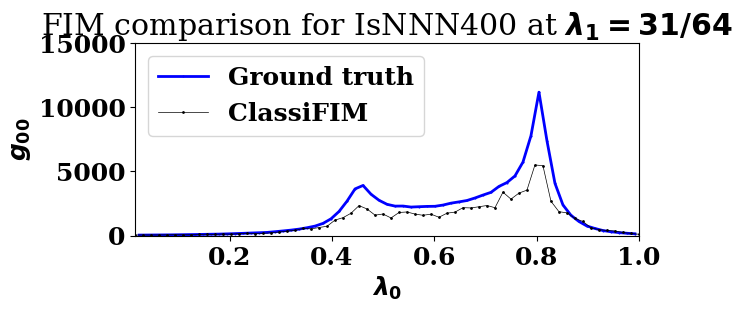

In [179]:
importlib.reload(classifim.bench.plot_tools)
font = {'family' : 'serif', 'weight' : 'bold', 'size'   : 18}
matplotlib.rc('font', **font)

FIG_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
file_name = os.path.join(FIG_DIR, f"fim_{ML_NAME}_" + "lambda{fixed_lambda_index}_{fixed_lambda_int_val}b-6_thin.png")
classifim.bench.plot_tools.plot_fim_df_1d(
    next(iter(gt_fims.values())),
    list(ml_fims.values()),
    fixed_lambda=(1, 30),
    ymax=15000,
    sm_name="IsNNN400",
    file_name=file_name,
    figsize=(6.5,2.5),
    savefig_kwargs={"dpi": 600},
    verbose=True # Change to True to print the file name
)

### 2D "phase" diagrams

* Requires:
    - Run "Load ChiFc" section above
* Produces 2D plots of ground truth and predicted fidelity susceptibility.

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/phase_naive-cnn_1.png'.


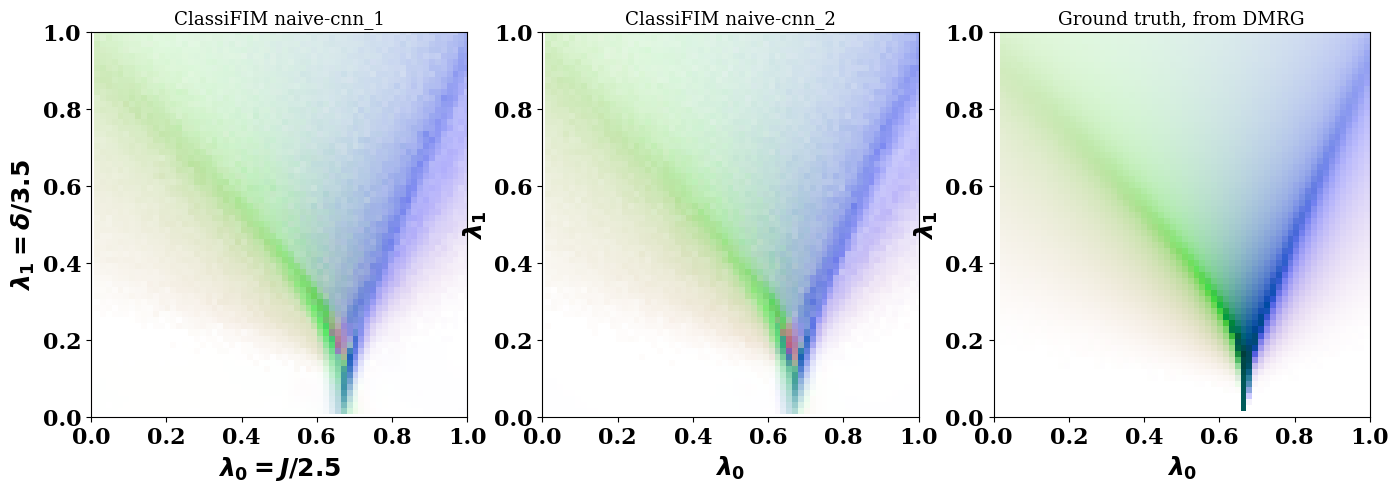

In [195]:
importlib.reload(classifim.bench.plot_tools)
FIG_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "figs")
res = plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(ncols=3, figsize=(3 * 5.5, 5))
(ax0, ax1, ax2) = axs

# classifim.bench.plot_tools.plot_fim_mgrid_legend(ax0, r0=0)

zz_max = 140
am_pairs = [(ax0, "naive-cnn_1"), (ax1, "naive-cnn_2")]
for ax, ml_name in am_pairs:
    classifim.bench.plot_tools.plot_fim_mgrid(ax, ml_fim_mgrids[ml_name], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
    ax.set_title(f"ClassiFIM {ml_name}")
ml_fim_seed = am_pairs[0][1]

ax0.set_xlabel("$\lambda_0 = J / 2.5$")
ax0.set_ylabel("$\lambda_1 = \delta / 3.5$")

classifim.bench.plot_tools.plot_fim_mgrid(ax2, gt_fim_mgrids[1], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
ax2.set_title("Ground truth, from DMRG")

file_name = os.path.join(FIG_DIR, f"phase_{ml_fim_seed}.png")
fig.savefig(file_name, bbox_inches='tight', dpi=600)
print(f"Saved to '{file_name}'.")

### Train logs

In [23]:
MODELS_DIR = os.path.join(DATA_DIR, "models")
train_logs_df = classifim.train_logs.read_logs(MODELS_DIR, permissive=True)
train_logs_summary_df = classifim.train_logs.aggregate_logs(train_logs_df)
train_logs_summary_df

Error reading '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/models/w-naive-cnn_01_0.log.json'
Error reading 'w-naive-cnn_01_0.log.json': Expecting value: line 1 column 1 (char 0)
Continuing... (permissive=True)


,,num_epochs,train_ce,train_ce.std,train_n,train_n.std,test_ce,test_ce.std,test_n,test_n.std,time,time.std,cnt
name,model_type,,,,,,,,,,,,
naive-cnn,ClassiFIM,200.0,0.075522,0.000179,1031928.0,17.410086,0.075706,0.000513,1146581.8,23.878396,1079.082927,21.575796,10
w-naive-cnn,W,6.0,0.142106,0.013499,258048.0,0.000000,NaN,NaN,-1.0,0.000000,555.575592,0.171474,19


### Compute dist metrics

* Requires:
    - Run "Load ChiFc" section above
* Produces: `metrics/dist_res.npz` with distSE values, distMSE & distRE metrics

In [104]:
METRICS_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "metrics")

def unroll_dict(d, key_name):
    res = {}
    for key in next(iter(d.values())).keys():
        res[key] = np.array([r[key] for r in d.values()])
    res[key_name] = np.array(list(d.keys()))
    return res

In [105]:
dist_res2 = {}

In [108]:
%%time
def compute_distance_errors_wrapper(key):
    m = re.match("^naive-cnn_([0-9]+)$", key)
    seed = int(m.group(1))
    prng = classifim.utils.DeterministicPrng(seed)
    cur_res = classifim.bench.metric.compute_distance_errors(
        ml_fim_mgrids[key], gt_fim_mgrids[seed], num_pairs=8386560,
        seed=prng.get_seed("compute_distance_errors"), use_cpp=True)
    return key, cur_res

with concurrent.futures.ThreadPoolExecutor() as executor:
    keys = list(ml_fim_mgrids.keys())
    for ml_fim_seed, cur_res in executor.map(compute_distance_errors_wrapper, keys):
        dist_res2[ml_fim_seed] = cur_res

CPU times: user 38min 29s, sys: 16 s, total: 38min 45s
Wall time: 4min 14s


In [109]:
dist_res_dict2 = unroll_dict(dist_res2, "ml_chifc_seed")
DIST_RES_PATH = os.path.join(METRICS_DIR, "dist_res.npz")
np.savez_compressed(DIST_RES_PATH, **dist_res_dict2)

In [110]:
DIST_RES_PATH = os.path.join(METRICS_DIR, "dist_res.npz")
with np.load(DIST_RES_PATH) as npz:
    dist_res_dict2 = dict(npz)

### Print dist metrics

In [111]:
METRICS_DIR = os.path.join(DATA_DIR, "metrics")
def load_metric_df(name):
    dist_res_filename = os.path.join(METRICS_DIR, f"{name}.npz")
    with np.load(dist_res_filename) as dist_res:
        df = {key: value for key, value in dist_res.items() if len(value.shape) == 1}
    df = pd.DataFrame(df)
    df.set_index("ml_chifc_seed", inplace=True)
    return df

def print_latex_summary(df):
    for column_name, values in df.items():
        digits = 4
        if 'distRE' in column_name:
            digits = 4
            values = values * 100
            column_name = column_name + r" (\%)"
        elif column_name.startswith("num_"):
            digits = 0
        print(f"{column_name}: ${classifim.bench.metric.normal_summary(values, digits=digits)}$")

In [112]:
df = load_metric_df("dist_res")
print_latex_summary(df)

num_pairs: $8386560 \pm 0$
distMSE: $10.9441 \pm 1.3333$
distRE (\%): $4.5130 \pm 0.3721$
distMSE_const: $55.5642 \pm 0.0246$
distRE_const (\%): $26.0643 \pm 0.0030$
distRE_perfect (\%): $0.0041 \pm 0.0005$
distMSE_perfect_scale: $4.6147 \pm 0.9095$
space_dim: $2.0000 \pm 0.0000$
scale: $1.1901 \pm 0.0102$


## Comparison with prior works

### W

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_phase_w-naive-cnn_01_0.png'.
Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_phase_w-naive-cnn_01_1.png'.


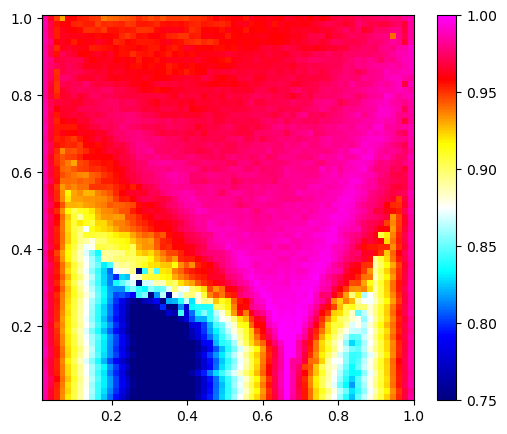

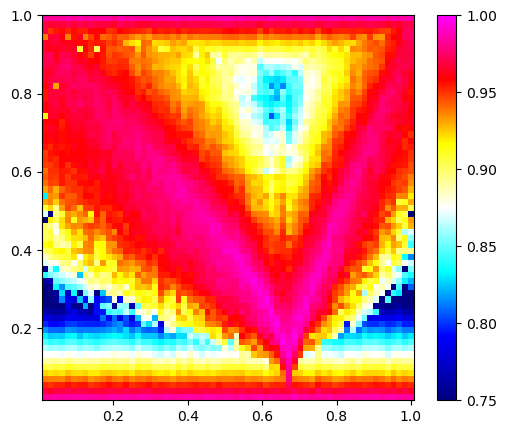

In [9]:
MODELS_DIR = os.path.join(DATA_DIR, "models")
w_npzs = []
for sweep_axis in [0, 1]:
    w_model_name = f"w-naive-cnn_01_{sweep_axis}"
    with np.load(os.path.join(MODELS_DIR, f"{w_model_name}.w.npz")) as f:
        w_npz = dict(f)
    w_npzs.append(w_npz)
    fig, ax = plt.subplots(ncols=1, figsize=(6, 5))
    classifim.bench.plot_tools.plot_w2d(
        ax, w_npz, colorbar=True, sweep_axis=sweep_axis)
    filename = os.path.join(DATA_DIR, "figs", f"isnnn400_phase_{w_model_name}.png")
    fig.savefig(filename, bbox_inches="tight", dpi=600)
    print(f"Saved to '{filename}'.")

### Huang's PCA

In [12]:
MODELS_DIR = os.path.join(DATA_DIR, "models")
pca_model_name = "pcaz_k_shadow_01"
with np.load(os.path.join(MODELS_DIR, f"{pca_model_name}.npz")) as f:
    pca = f["pca"]
    suffix = f["suffix"]

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_phase_pcaz_k_shadow_01.png'.


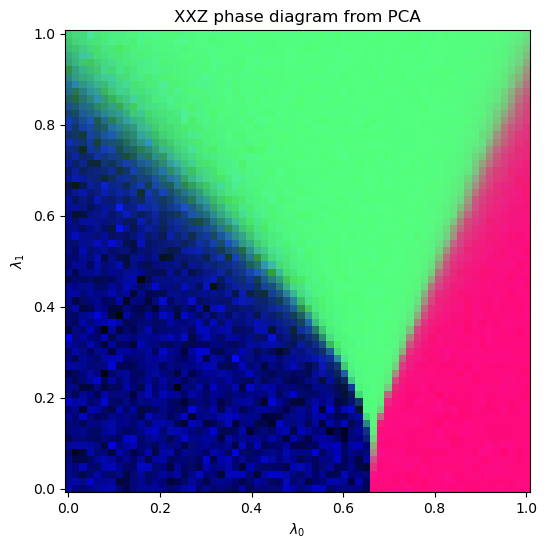

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
classifim.bench.plot_tools.plot_pca(ax, pca)
filename = os.path.join(DATA_DIR, "figs", f"isnnn400_phase_{pca_model_name}.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

### Peaks

#### GT

In [38]:
importlib.reload(classifim.bench.peaks)
gt_peaks = {}
for sweep_lambda_index in [0, 1]:
    for seed, gt_fim in gt_fims.items():
        gt_mg = classifim.bench.peaks.extract_gt_meshgrid(
            gt_fim, sweep_lambda_index=sweep_lambda_index)
        gt_peaks[seed, sweep_lambda_index] = classifim.bench.peaks.get_gt_peaks(
            gt_mg=gt_mg, min_prominence=100.0)

In [40]:
seed = 1
sweep_lambda_index = 0
cur_gt_peaks = gt_peaks[seed, sweep_lambda_index]

#### PCA

In [121]:
MODELS_DIR = os.path.join(DATA_DIR, "models")
dataset_name = f"{seed}"
seed = int(dataset_name)
pca_filename = f"pcaz_k_shadow_{dataset_name}.npz"
with np.load(os.path.join(MODELS_DIR, pca_filename)) as f:
    pca = f["pca"]
lambda0s = lambda1s = np.arange(1, 65) / 64
pca_peaks = classifim.bench.peaks.get_pca_peaks(
    lambda1s, lambda0s, pca=pca[:, :, :2],
    num_peaks=cur_gt_peaks["num_peaks"],
    postprocess=True,
    sweep_lambda_index=sweep_lambda_index)

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_pca_peaks.png.


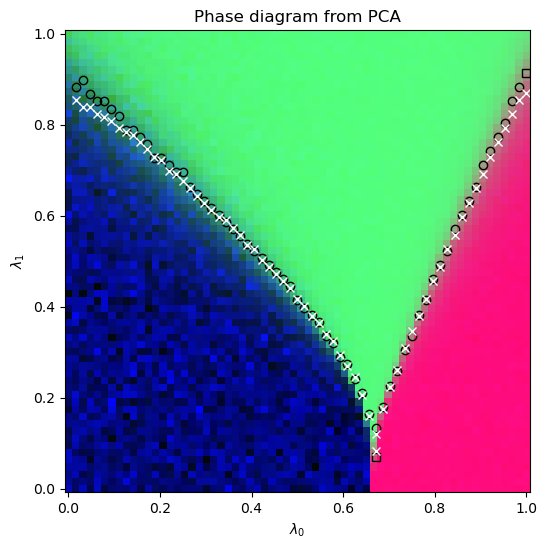

In [122]:
importlib.reload(classifim.bench.plot_tools)
fig, ax = plt.subplots(figsize=(6, 6))
classifim.bench.plot_tools.plot_pca(ax, pca)
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks)
xs, ys = pca_peaks["lambda_sweep"], pca_peaks["lambda_fixed"]
if sweep_lambda_index:
    xs, ys = ys, xs
ax.plot(xs, ys, 'x', mfc='none', mec='white')
file_name = os.path.join(DATA_DIR, "figs", "isnnn400_pca_peaks.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

#### ClassiFIM

In [60]:
seed = 10
ml_model_name = f"naive-cnn_{seed}"
ml_mg = classifim.bench.peaks.extract_ml_meshgrid(
    ml_fim_mgrids[ml_model_name], sweep_lambda_index)
classifim_peaks = classifim.bench.peaks.get_classifim_peaks(
    ml_mg,
    num_peaks=cur_gt_peaks["num_peaks"],
    lambda_fixed_expected=cur_gt_peaks["lambda_fixed"],
    lambda_fixed_tolerance=2**(-23), # np.float32 ulp
    postprocess=True)

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_classifim_peaks.png.


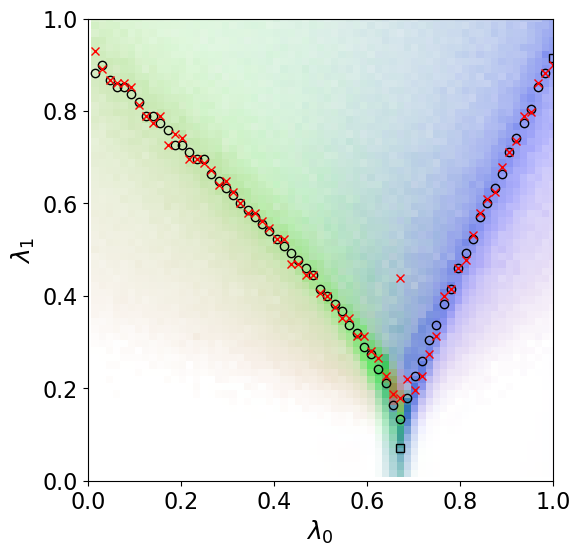

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
zz_max = 140
classifim.bench.plot_tools.plot_fim_mgrid(
    ax, ml_fim_mgrids[ml_model_name], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks)
xs, ys = classifim_peaks["lambda_sweep"], classifim_peaks["lambda_fixed"]
if sweep_lambda_index:
    xs, ys = ys, xs
ax.plot(xs, ys, 'x', mfc='none', mec='red')
file_name = os.path.join(DATA_DIR, "figs", "isnnn400_classifim_peaks.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_classifim_peaks_1d.png.


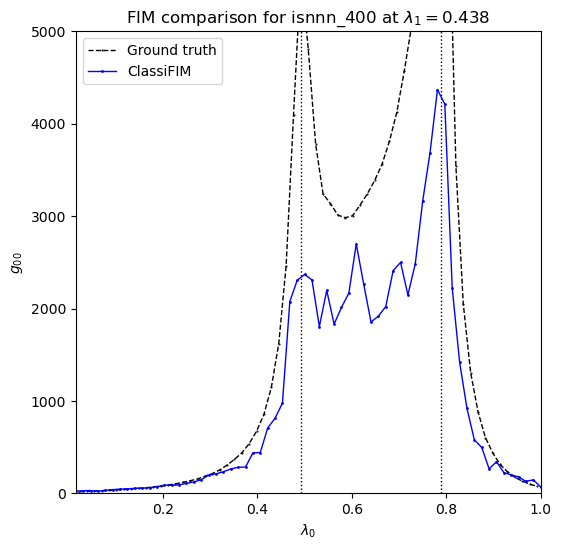

In [62]:
importlib.reload(classifim.bench.plot_tools)
fig, ax = plt.subplots(figsize=(6, 6))
ymax = 5000
plot_fim_df_res = classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[seed],
    [ml_fims[f"naive-cnn_{seed}"]],
    fixed_lambda=(1, 27),
    resolution=63,
    ymax=ymax,
    sm_name=SM_NAME,
    fim_vlines=True,
    ax=ax)
file_name = os.path.join(DATA_DIR, "figs", "isnnn400_classifim_peaks_1d.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

#### W

In [63]:
w_model_name = f"w-naive-cnn_{seed:02d}"
w_filename = f"{w_model_name}_{sweep_lambda_index}.w.npz"
with np.load(os.path.join(MODELS_DIR, w_filename)) as f:
    w_npz = dict(f)
w_peaks = classifim.bench.peaks.get_w_peaks(
    lambda_fixed=w_npz["lambda_fixed"],
    lambda_sweep=w_npz["lambda_sweep_thresholds"],
    w_accuracy=w_npz["accuracy"],
    num_peaks=cur_gt_peaks["num_peaks"],
    lambda_fixed_expected=cur_gt_peaks["lambda_fixed"],
    postprocess=True)

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_w_peaks.png.


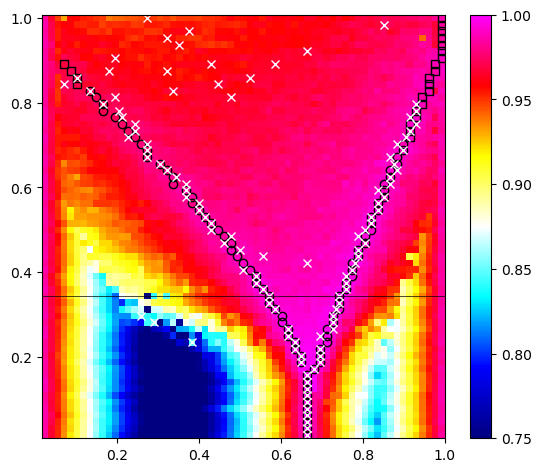

In [51]:
importlib.reload(classifim.bench.plot_tools)
fig, ax = plt.subplots(figsize=(6.5, 5.5))
classifim.bench.plot_tools.plot_w2d(
    ax, w_npz, sweep_axis=sweep_lambda_index, colorbar=True)
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks)
xs, ys = w_peaks["lambda_sweep"], w_peaks["lambda_fixed"]
if sweep_lambda_index:
    xs, ys = ys, xs
ax.plot(
    xs, ys,
    'x', mfc='none', mec='white')
lambda_fixed_i = 21
lambda_fixed = (1 + lambda_fixed_i) / 64
(ax.axvline if sweep_lambda_index else ax.axhline)(
    lambda_fixed, color='black', linewidth=0.5)
file_name = os.path.join(DATA_DIR, "figs", "isnnn400_w_peaks.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_w_peaks_1d.png.


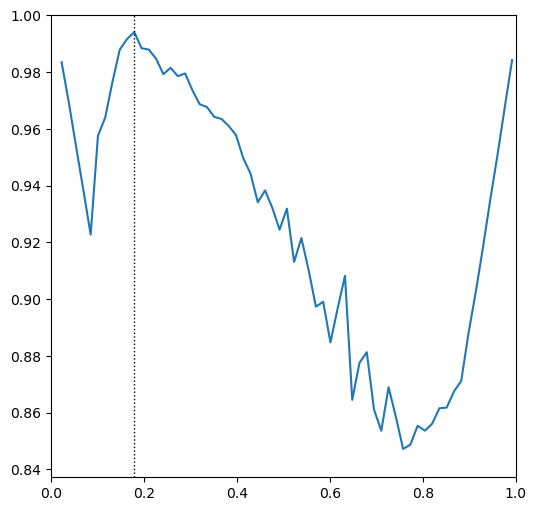

In [69]:
fig, ax = plt.subplots(figsize=(6, 6))
classifim.bench.plot_tools.plot_w1d(ax, w_npz, lambda_v=lambda_sweep)
for vline in cur_gt_peaks['lambda_sweep'][cur_gt_peaks['lambda_fixed_ii'] == lambda_sweep_i]:
    ax.axvline(vline, color='black', linestyle=':', linewidth=1.0)
file_name = os.path.join(DATA_DIR, "figs", "isnnn400_w_peaks_1d.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

#### Peak metrics

In [74]:
%%time
importlib.reload(classifim.bench.peaks)
MODELS_DIR = os.path.join(DATA_DIR, "models")
all_peak_errors = []
for (seed, sweep_lambda_index), cur_gt_peaks in gt_peaks.items():
    gt_num_peaks, gt_lambda_fixed = [
        cur_gt_peaks[key] for key in ["num_peaks", "lambda_fixed"]]
    cur_peaks = {}
    methods = ["classifim"]
    ml_model_name = f"naive-cnn_{seed}"
    ml_mg = classifim.bench.peaks.extract_ml_meshgrid(
        ml_fim_mgrids[ml_model_name], sweep_lambda_index)
    ml_peaks, ml_smooth_peaks = [
        classifim.bench.peaks.get_classifim_peaks(
            ml_mg,
            num_peaks=gt_num_peaks,
            lambda_fixed_expected=gt_lambda_fixed,
            lambda_fixed_tolerance=2**(-23), # np.float32 ulp
            postprocess=postprocess)
        for postprocess in [False, True]]
    cur_peaks[f"classifim_peaks"] = ml_peaks
    cur_peaks[f"classifim_smooth_peaks"] = ml_smooth_peaks

    methods.append("w")
    w_model_name = f"w-naive-cnn_{seed:02d}"
    w_filename = f"{w_model_name}_{sweep_lambda_index}.w.npz"
    with np.load(os.path.join(MODELS_DIR, w_filename)) as f:
        w_npz = dict(f)
    cur_peaks["w_peaks"], cur_peaks["w_smooth_peaks"] = [
        classifim.bench.peaks.get_w_peaks(
            lambda_fixed=w_npz["lambda_fixed"],
            lambda_sweep=w_npz["lambda_sweep_thresholds"],
            w_accuracy=w_npz["accuracy"],
            num_peaks=gt_num_peaks,
            lambda_fixed_expected=gt_lambda_fixed,
            postprocess=postprocess)
        for postprocess in [False, True]]
    methods.append("pca")
    pca_filename = f"pcaz_k_shadow_{seed:02d}.npz"
    with np.load(os.path.join(MODELS_DIR, pca_filename)) as f:
        pca = f["pca"]
    lambda0s = lambda1s = np.arange(64) / 63
    cur_peaks["pca_peaks"], cur_peaks["pca_smooth_peaks"] = [
        classifim.bench.peaks.get_pca_peaks(
            lambda1s, lambda0s, pca=pca[..., :2], num_peaks=gt_num_peaks,
            postprocess=postprocess, sweep_lambda_index=sweep_lambda_index)
        for postprocess in [False, True]]
    peak_errors = classifim.bench.peaks.compute_peak_rmses(cur_gt_peaks, cur_peaks)
    peak_errors["seed"] = seed
    peak_errors["sweep_lambda_index"] = sweep_lambda_index
    peak_errors["num_peaks"] = np.sum(cur_gt_peaks["is_inner"])
    peak_errors["methods"] = methods
    all_peak_errors.append(peak_errors)

CPU times: user 1min 27s, sys: 4.34 s, total: 1min 31s
Wall time: 15.3 s


In [88]:
dfs = []
metric_names = ["peaks", "peaks_single", "smooth_peaks", "smooth_peaks_single"]
for cur_peak_errors in all_peak_errors:
    cur_df = {
        key: cur_peak_errors[key]
        for key in ["seed", "sweep_lambda_index", "num_peaks"]}
    cur_df["method_name"] = []
    cur_df.update(**{
        sa + "peaks" + sb: []
        for sa in ("", "smooth_")
        for sb in ("", "_single")
    })
    for method_name in cur_peak_errors["methods"]:
        cur_df["method_name"].append(method_name)
        for metric_name in metric_names:
            cur_df[metric_name].append(
                cur_peak_errors[method_name + "_" + metric_name])
    dfs.append(pd.DataFrame(cur_df))
peak_metrics_df_raw = pd.concat(dfs, ignore_index=True)

peak_metrics_df = peak_metrics_df_raw.copy()
for metric_name in metric_names:
    peak_metrics_df[metric_name] = peak_metrics_df[metric_name]**2 * peak_metrics_df["num_peaks"]
peak_metrics_df = peak_metrics_df.groupby(['seed', 'method_name']).agg(
    num_peaks=('num_peaks', 'sum'),
    num_rows=('num_peaks', 'size'),
    **{metric_name: (metric_name, 'sum') for metric_name in metric_names})
for metric_name in metric_names:
    peak_metrics_df[metric_name] = (peak_metrics_df[metric_name] / peak_metrics_df["num_peaks"])**0.5
peak_metrics_df.reset_index(inplace=True)

In [89]:
peak_metrics_df #[peak_metrics_df["method_name"] == "classifim"].sort_values("smooth_peaks")

,seed,method_name,num_peaks,num_rows,peaks,peaks_single,smooth_peaks,smooth_peaks_single
0,1,classifim,150,2,0.056069,0.030585,0.025146,0.029399
1,1,pca,150,2,0.016267,0.013639,0.015785,0.012817
2,1,w,150,2,0.090742,0.159133,0.032256,0.079002
3,2,classifim,151,2,0.044080,0.018150,0.016407,0.016134
4,2,pca,151,2,0.018642,0.016095,0.017277,0.014862
5,2,w,151,2,0.091706,0.152158,0.034660,0.066507
6,3,classifim,149,2,0.045676,0.014588,0.014326,0.013940
7,3,pca,149,2,0.015234,0.012907,0.014879,0.012618
8,3,w,149,2,0.078515,0.156173,0.037232,0.062728
9,4,classifim,150,2,0.023987,0.016247,0.014178,0.015629


In [103]:
classifim.bench.peaks.paired_t_tests(peak_metrics_df, metric_name="smooth_peaks", verbose=True);

classifim vs pca: 0.017 ≈ 0.016 (t-stat=1.342, p=0.213)
classifim vs w: 0.017 < 0.035 (t-stat=-6.130, p=0.000)
pca vs w: 0.016 < 0.035 (t-stat=-9.099, p=0.000)


In [90]:
dfg = peak_metrics_df.groupby("method_name").agg(**{
    metric + ("" if fun == "mean" else "." + fun): (metric, fun)
    for metric in metric_names
    for fun in ["mean", "std"]})
dfg

,peaks,peaks.std,peaks_single,peaks_single.std,smooth_peaks,smooth_peaks.std,smooth_peaks_single,smooth_peaks_single.std
method_name,,,,,,,,
classifim,0.033162,0.012394,0.019190,0.005019,0.017291,0.003791,0.018060,0.005010
pca,0.016297,0.001106,0.013919,0.000948,0.015672,0.000733,0.013008,0.000732
w,0.085256,0.006846,0.146167,0.015510,0.035296,0.006735,0.067203,0.011294


### Multi-panel figures

#### 2x2 and 1x7

NameError: name 'pca' is not defined

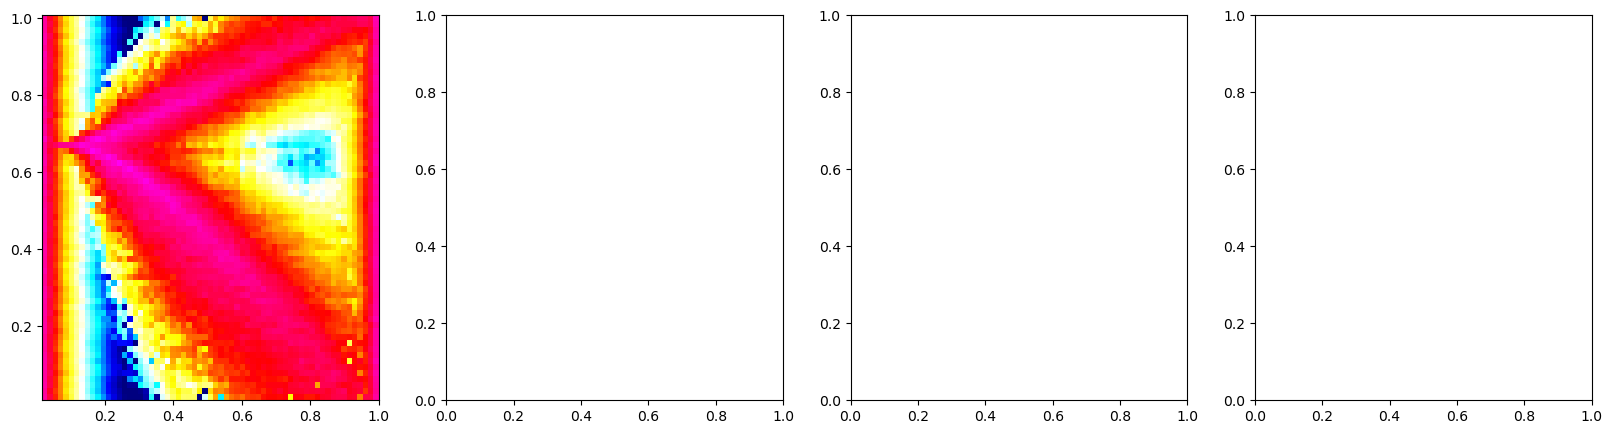

In [10]:
# 1x4
fig, axs = plt.subplots(ncols=4, figsize=(4 * 5, 5))
ax0, ax1, ax2, ax3 = axs
classifim.bench.plot_tools.plot_w2d(ax0, w_npzs[0], colorbar=False)
classifim.bench.plot_tools.plot_pca(ax1, pca)
# ax1.set_title("W")
zz_max = 140
classifim.bench.plot_tools.plot_fim_mgrid(ax2, ml_fim_mgrids["naive-cnn_1"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(ax3, gt_fim_mgrids[1], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax3.set_title("Ground truth, from DMRG")
for ax in axs:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)
fig.tight_layout()
filename = os.path.join(DATA_DIR, "figs", f"isnnn400_phase_1x4.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_phase_2x2.png'.


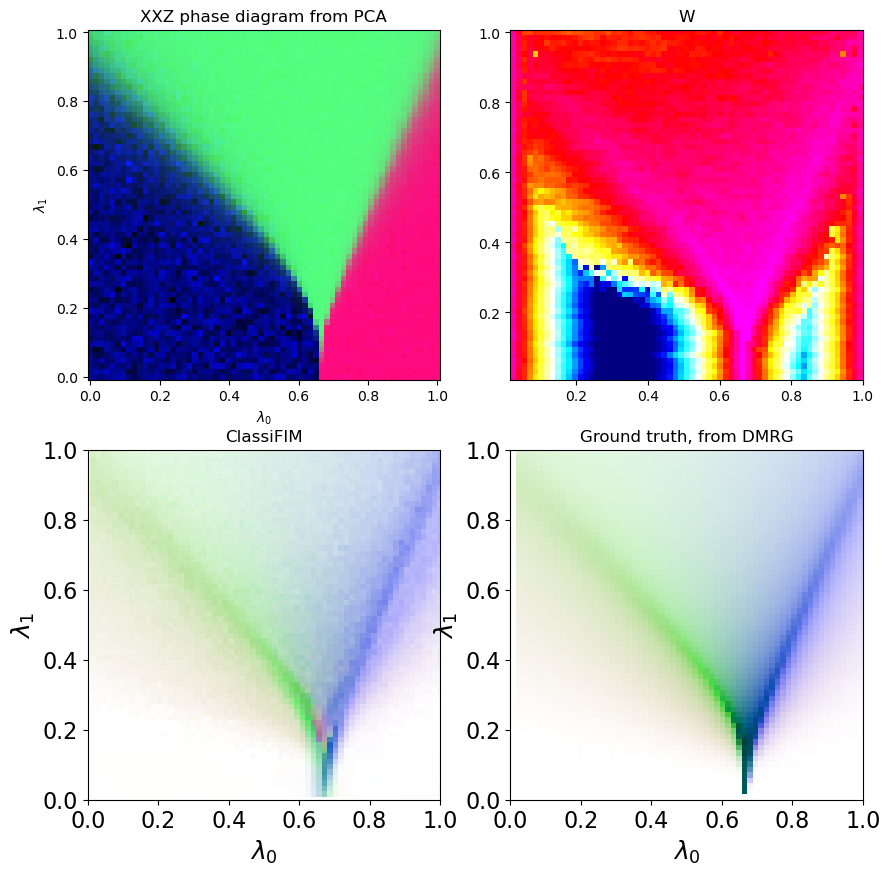

In [12]:
# 2x2
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
(ax0, ax1), (ax2, ax3) = axs
classifim.bench.plot_tools.plot_pca(ax0, pca)
classifim.bench.plot_tools.plot_w2d(ax1, w_npzs[0], colorbar=False)
ax1.set_title("W")
zz_max = 140
classifim.bench.plot_tools.plot_fim_mgrid(ax2, ml_fim_mgrids["naive-cnn_1"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(ax3, gt_fim_mgrids[1], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
ax3.set_title("Ground truth, from DMRG")
filename = os.path.join(DATA_DIR, "figs", f"isnnn400_phase_2x2.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

Grayed out regions are 2 standard deviations from the mean.
Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_phase_1x7.png'.


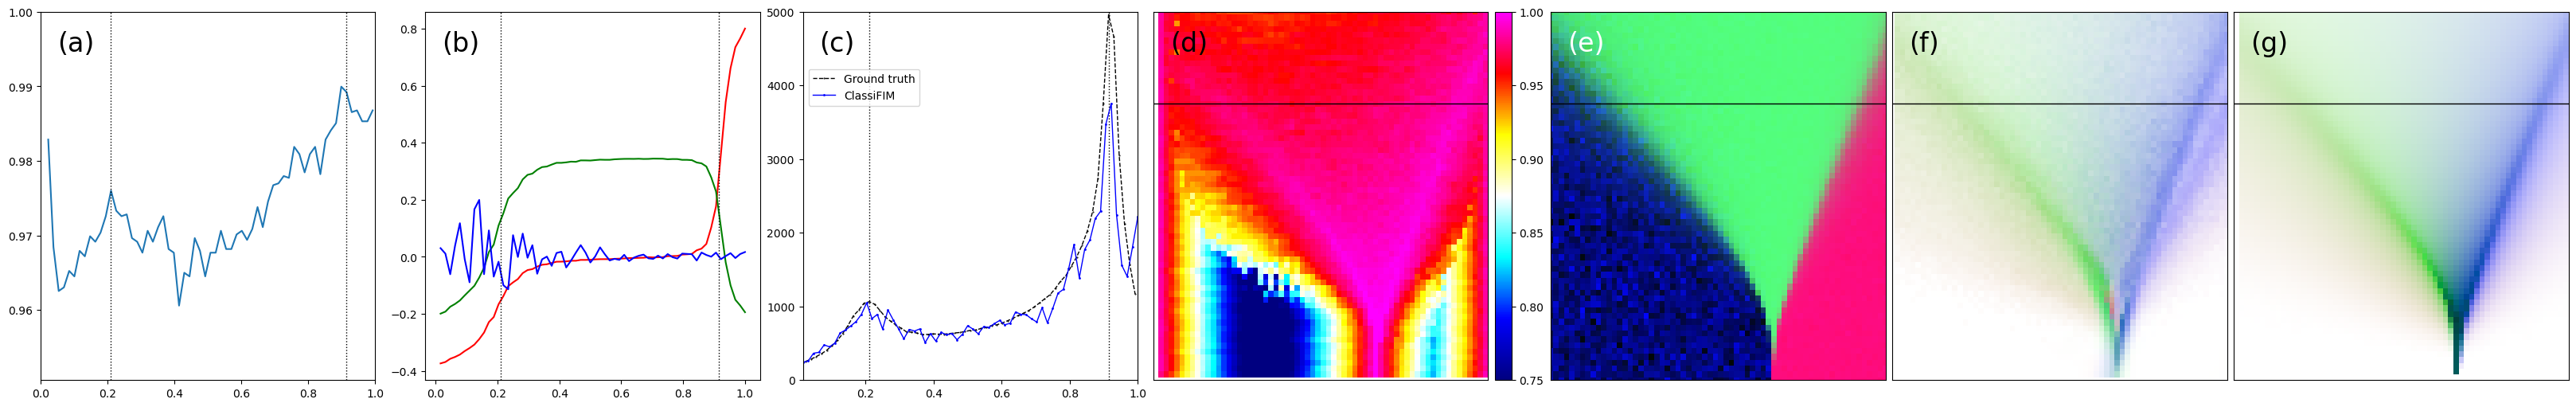

In [16]:
importlib.reload(classifim.bench.plot_tools)
png_scale = 1.0
fig = plt.figure(figsize=(32.25 * png_scale, 5.0 * png_scale), layout='constrained') # TODO:5:check what constrained_layout does.
gs = matplotlib.gridspec.GridSpec(
    1, 8, width_ratios=[1, 1, 1, 1, 0.05, 1, 1, 1], figure=fig)
axs_1d = [fig.add_subplot(gs[0, i]) for i in [0, 1, 2]]
axs_2d = [fig.add_subplot(gs[0, i]) for i in [3, 5, 6, 7]]
cbar_ax0_2d, = cbar_axs = [fig.add_subplot(gs[0, i]) for i in [4]]

lambda1i = 47
lambda1 = (1 + lambda1i) / 64
classifim.bench.plot_tools.plot_w1d(axs_1d[0], w_npzs[0], lambda_v=lambda1)
for i in range(3):
    axs_1d[1].plot(np.arange(1, 65) / 64, pca[:, lambda1i, i], color=['red', 'green', 'blue'][i])

ymax = 5000
plot_fim_df_res = classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[1],
    [ml_fims["naive-cnn_1"]],
    fixed_lambda=(1, lambda1i),
    resolution=64,
    ymax=ymax,
    sm_name=SM_NAME,
    fim_vlines=True,
    ax=axs_1d[2])
axs_1d[2].set_title(None)
axs_1d[2].set_xlabel(None)
axs_1d[2].set_ylabel(None)
axs_1d[2].legend(loc='upper left', bbox_to_anchor=(0, 0.86))

for ax in axs_1d[:2]:
    for vline in plot_fim_df_res["fim_vlines"]:
        ax.axvline(vline, color='black', linestyle=':', linewidth=1.0)

classifim.bench.plot_tools.plot_w2d(axs_2d[0], w_npzs[0], colorbar=True, cbar_ax=cbar_ax0_2d)
classifim.bench.plot_tools.plot_pca(axs_2d[1], pca)
# ax1.set_title("W")
zz_max = 140
classifim.bench.plot_tools.plot_fim_mgrid(axs_2d[2], ml_fim_mgrids["naive-cnn_1"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(axs_2d[3], gt_fim_mgrids[1], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax3.set_title("Ground truth, from DMRG")
for ax in axs_2d:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)
    ax.axhline(lambda1, color='black', linewidth=1)

for i, ax in enumerate(axs_1d + axs_2d):
    panel_label = f'({chr(97 + i)})'  # 97 is the ASCII code for 'a'
    # Position the text at the top left corner of the panel
    # Adjust x and y values as needed to fit your specific figure layout
    ax.text(0.05, 0.95, panel_label, transform=ax.transAxes, fontsize=24,
            verticalalignment='top', horizontalalignment='left',
            color=('white' if ax == axs_2d[1] else 'black'))

filename = os.path.join(DATA_DIR, "figs", f"isnnn400_phase_1x7.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

Saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_phase_1x7_paper.png'.


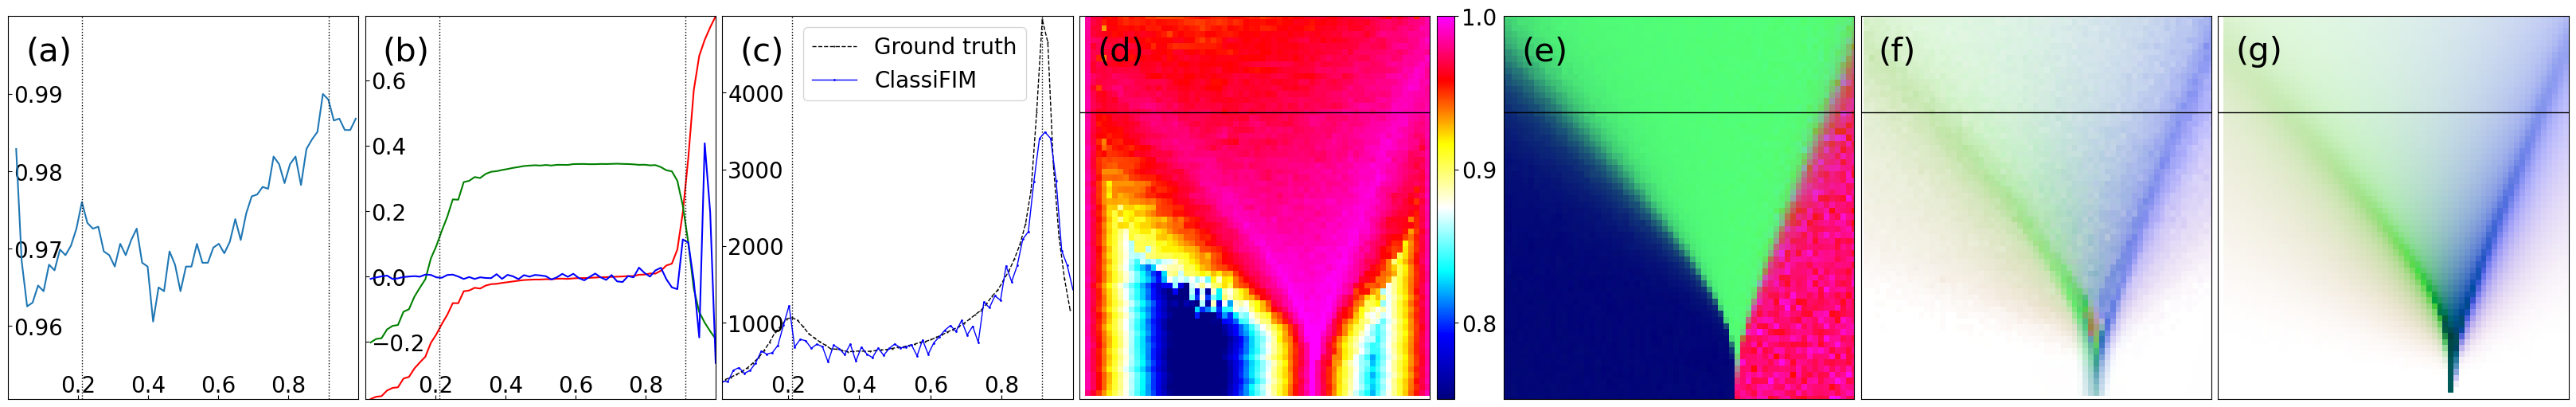

In [186]:
# Same, but with large font
importlib.reload(classifim.bench.plot_tools)
png_scale = 1.0
# layout='constrained' avoids overlaps and removes unnecessary space between the panels:
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
fig = plt.figure(
    figsize=(32.25 * png_scale, 5.0 * png_scale),
    layout='constrained')
gs = matplotlib.gridspec.GridSpec(
    1, 8, width_ratios=[1, 1, 1, 1, 0.05, 1, 1, 1], figure=fig)
axs_1d = [fig.add_subplot(gs[0, i]) for i in [0, 1, 2]]
axs_2d = [fig.add_subplot(gs[0, i]) for i in [3, 5, 6, 7]]
cbar_ax0_2d, = cbar_axs = [fig.add_subplot(gs[0, i]) for i in [4]]

lambda1i = 47
lambda1 = PARAMETER_GRID_EXPANDED[1][lambda1i]

# (a)
classifim.bench.plot_tools.plot_w1d(axs_1d[0], w_npzs[0], lambda_v=lambda1)
axs_1d[0].set_yticks([0.96, 0.97, 0.98, 0.99])

# (b)
for i in range(3):
    axs_1d[1].plot(PARAMETER_GRID_EXPANDED[0], pca[:, lambda1i, i], color=['red', 'green', 'blue'][i])
axs_1d[1].set_xlim((0, 1))
axs_1d[1].set_ylim((np.min(pca[:, lambda1i, :3]), np.max(pca[:, lambda1i, :3])))
axs_1d[1].set_yticks(np.linspace(-0.2, 0.6, 5))

# (c)
ymax = 5000
plot_fim_df_res = classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[1],
    [ml_fims[f"naive-cnn_{seed}"]],
    fixed_lambda=(1, lambda1i),
    resolution=63,
    ymax=ymax,
    sm_name=SM_NAME,
    fim_vlines=True,
    ax=axs_1d[2])
axs_1d[2].set_title(None)
axs_1d[2].set_xlabel(None)
axs_1d[2].set_ylabel(None)
axs_1d[2].legend(loc='upper left', bbox_to_anchor=(0.2, 1.0), fontsize=20)
axs_1d[2].set_yticks(np.arange(1, 5) * 1e3)

for ax in axs_1d:
    ax.tick_params(axis='x', direction='in', pad=-22, labelsize=20)
    ax.set_xticks([0.2, 0.4, 0.6, 0.8])
    ax.tick_params(axis='y', direction='in', pad=-5, labelsize=20)
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')


for ax in axs_1d[:2]:
    for vline in plot_fim_df_res["fim_vlines"]:
        ax.axvline(vline, color='black', linestyle=':', linewidth=1.0)

classifim.bench.plot_tools.plot_w2d(axs_2d[0], w_npzs[0], colorbar=True, cbar_ax=cbar_ax0_2d)
cbar_ax0_2d.tick_params(axis='y', labelsize=20)
cbar_ax0_2d.set_yticks([0.8, 0.9, 1.0])
classifim.bench.plot_tools.plot_pca(axs_2d[1], pca)
# ax1.set_title("W")
zz_max = 140
classifim.bench.plot_tools.plot_fim_mgrid(axs_2d[2], ml_fim_mgrids[f"naive-cnn_{seed}"], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax2.set_title("ClassiFIM")
classifim.bench.plot_tools.plot_fim_mgrid(axs_2d[3], gt_fim_mgrids[1], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
# ax3.set_title("Ground truth, from DMRG")
for ax in axs_2d:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)
    ax.axhline(lambda1, color='black', linewidth=1)

for i, ax in enumerate(axs_1d + axs_2d):
    panel_label = f'({chr(97 + i)})'  # 97 is the ASCII code for 'a'
    # Position the text at the top left corner of the panel
    # Adjust x and y values as needed to fit your specific figure layout
    ax.text(0.05, 0.95, panel_label, transform=ax.transAxes, fontsize=30,
            verticalalignment='top', horizontalalignment='left',
            color='black')

filename = os.path.join(DATA_DIR, "figs", f"isnnn400_phase_1x7_paper.png")
fig.savefig(filename, bbox_inches="tight", dpi=600)
print(f"Saved to '{filename}'.")

#### 1x4 W explained

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_modw_1x4_details.png.


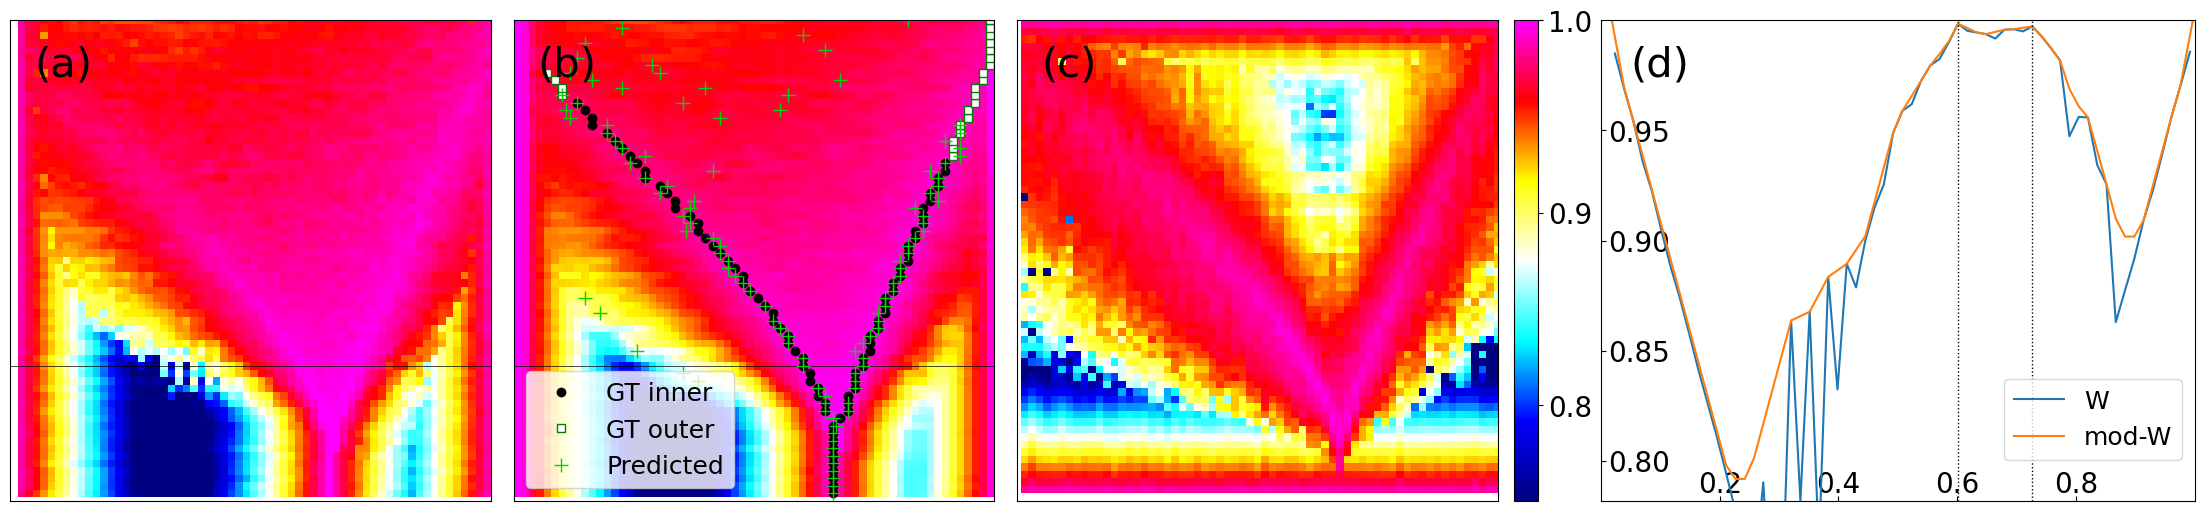

In [197]:
w_npzs = []
seed = 10
for sweep_axis in [0, 1]:
    w_model_name = f"w-naive-cnn_{seed:02d}_{sweep_axis}"
    with np.load(os.path.join(MODELS_DIR, f"{w_model_name}.w.npz")) as f:
        w_npz = dict(f)
    w_npzs.append(w_npz)
png_scale = 1.0
# layout='constrained' avoids overlaps and removes unnecessary space between the panels:
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
fig = plt.figure(
    figsize=(22 * png_scale, 5 * png_scale),
    layout='constrained')
gs = matplotlib.gridspec.GridSpec(
    1, 5, width_ratios=[1, 1, 1, 0.05, 1.2], figure=fig)
axs_w2d = [fig.add_subplot(gs[0, i]) for i in [0, 1, 2]]
ax_w2d_cbar = fig.add_subplot(gs[0, 3])
ax_w1d = fig.add_subplot(gs[0, 4])

w_npz = w_npzs[0]
w_peaks = classifim.bench.peaks.get_w_peaks(
    lambda_fixed=w_npz["lambda_fixed"],
    lambda_sweep=w_npz["lambda_sweep_thresholds"],
    w_accuracy=w_npz["accuracy"],
    num_peaks=cur_gt_peaks["num_peaks"],
    lambda_fixed_expected=cur_gt_peaks["lambda_fixed"],
    postprocess=True,
    return_pp=True)
lambda_fixed_i = 17
lambda_fixed = (1 + lambda_fixed_i) / 64

classifim.bench.plot_tools.plot_w2d(
    axs_w2d[0], w_npzs[0], cbar_ax=ax_w2d_cbar, sweep_axis=0)
classifim.bench.plot_tools.ax_sweepline(
    axs_w2d[0], lambda_fixed, sweep_axis=sweep_lambda_index)
ax_w2d_cbar.tick_params(axis='y', labelsize=20)
ax_w2d_cbar.set_yticks([0.8, 0.9, 1.0])

ax = axs_w2d[1]
classifim.bench.plot_tools.plot_w2d(
    ax, w_peaks["pp"], sweep_axis=0)
classifim.bench.plot_tools.ax_sweepline(
    ax, lambda_fixed, sweep_axis=sweep_lambda_index)
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks,
    style_inner=dict(mfc=(0, 0, 0)),
    style_outer=dict(mfc=(1, 1, 1)))
classifim.bench.plot_tools.plot_predicted_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, predicted_peaks=w_peaks,
    marker='+', mec=(0.04, 0.82, 0.02), ms=10)

classifim.bench.plot_tools.plot_w2d(
    axs_w2d[2], w_npzs[1], sweep_axis=1)

axs_w2d[1].legend(fontsize=18)

for ax in axs_w2d:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_aspect('equal', adjustable='box')
    
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)

classifim.bench.plot_tools.plot_w1d(ax_w1d, w_npzs[0], lambda_v=lambda_fixed, label='W')
classifim.bench.plot_tools.plot_w1d(ax_w1d, w_peaks["pp"], lambda_v=lambda_fixed, label='mod-W')
import scipy.signal
fim_df = gt_fims[seed]
fim_slice = fim_df[fim_df[f"lambda{1 - sweep_axis}"] == lambda_fixed]
vline_ids = scipy.signal.find_peaks(fim_slice["fim"], prominence=20)[0]
fim_vlines = np.asarray(fim_slice[f"lambda{sweep_axis}"].iloc[vline_ids])
for vline in plot_fim_df_res["fim_vlines"]:
    ax_w1d.axvline(vline, color='black', linestyle=':', linewidth=1.0)

ax_w1d.set_xticks([0.2, 0.4, 0.6, 0.8])
ax_w1d.tick_params(axis='x', direction='in', pad=-22, labelsize=20)
ax_w1d.set_yticks([0.8, 0.85, 0.9, 0.95])
ax_w1d.tick_params(axis='y', direction='in', pad=-5, labelsize=20)
for label in ax_w1d.get_yticklabels():
    label.set_horizontalalignment('left')
ax_w1d.legend(fontsize=18, loc='lower right', bbox_to_anchor=(1.0, 0.06))

for i, ax in enumerate(axs_w2d + [ax_w1d]):
    panel_label = f'({chr(97 + i)})'  # 97 is the ASCII code for 'a'
    # Position the text at the top left corner of the panel
    # Adjust x and y values as needed to fit your specific figure layout
    ax.text(0.05, 0.95, panel_label, transform=ax.transAxes, fontsize=30,
            verticalalignment='top', horizontalalignment='left',
            color='black')

file_name = os.path.join(DATA_DIR, "figs", "isnnn400_modw_1x4_details.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

Saved to /media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/isnnn_400/figs/isnnn400_modcf_1x4_details.png.


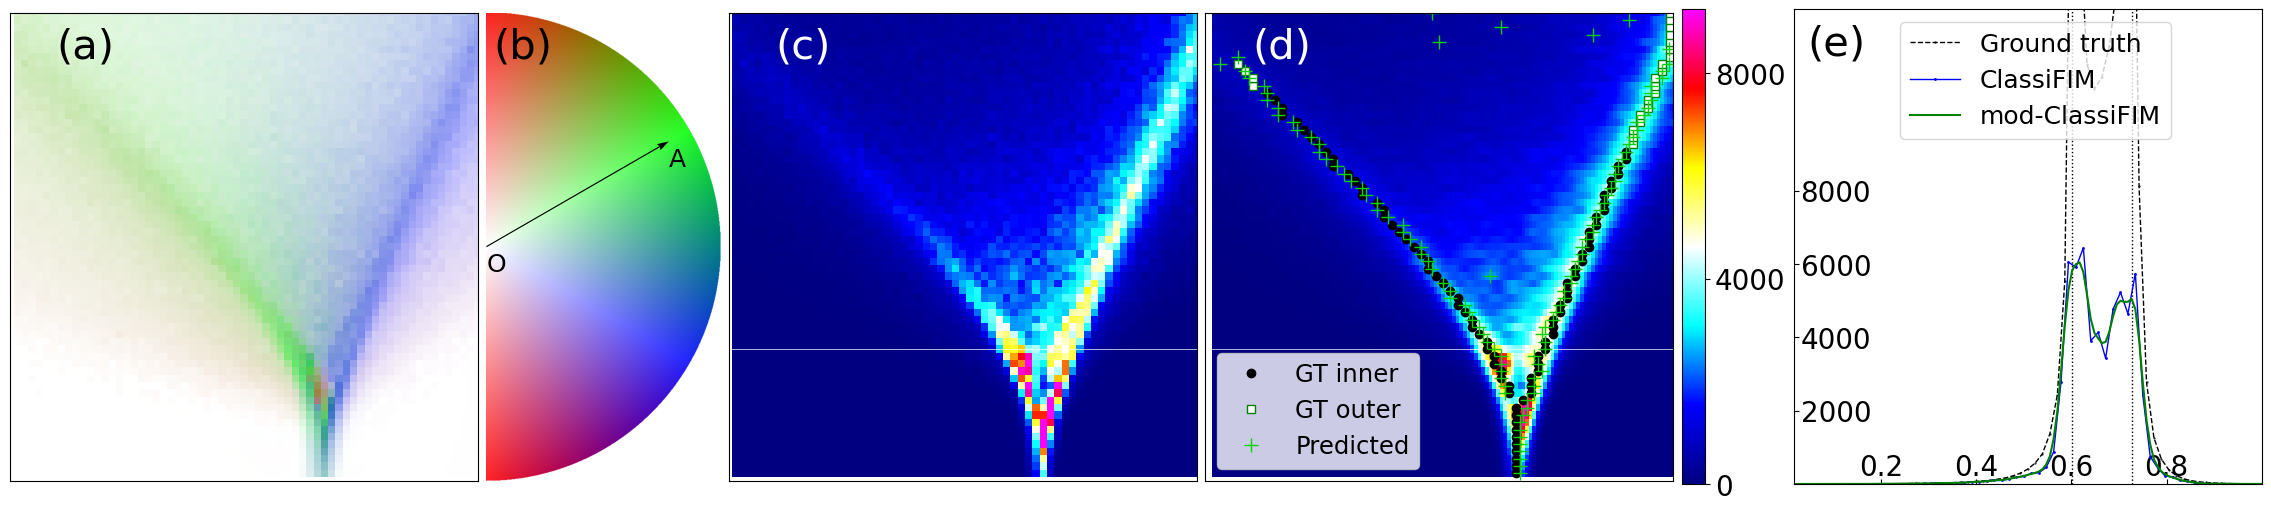

In [220]:
importlib.reload(classifim.bench.peaks)
importlib.reload(classifim.bench.plot_tools)
seed = 10
sweep_axis = 0
png_scale = 1.0
def max_of_second_highest(z: np.ndarray) -> float:
    assert z.ndim == 2, "Input must be a 2D array"
    return np.max(np.partition(z, -2, axis=1)[:, -2])
fig = plt.figure(
    figsize=(22.6 * png_scale, 5 * png_scale),
    layout='constrained')
gs = matplotlib.gridspec.GridSpec(
    1, 6, width_ratios=[1, 0.5, 1, 1, 0.05, 1], figure=fig)
axs_cf2d = [fig.add_subplot(gs[0, i]) for i in [0, 2, 3]]
axs_cf2d_cbar = [fig.add_subplot(gs[0, i]) for i in [1, 4]]
ax_cf1d = fig.add_subplot(gs[0, 5])

zz_max = 140
ml_model_name = f"naive-cnn_{seed}"
classifim.bench.plot_tools.plot_fim_mgrid(
    axs_cf2d[0], ml_fim_mgrids[ml_model_name], zz_max=zz_max, xlim=(0, 1), ylim=(0, 1))
classifim.bench.plot_tools.plot_fim_mgrid_legend(
    axs_cf2d_cbar[0], r0=1, xlim=(0, 1))
pos_a = 0.9 * np.array((3**0.5/2, 1/2))
arrow_scale = 2
axs_cf2d_cbar[0].quiver(
    0, 0, *pos_a, angles='xy', scale_units='xy', scale=1, color='black',
    width=0.005, headwidth=3 * arrow_scale, headlength=5 * arrow_scale, headaxislength=4.5 * arrow_scale)
axs_cf2d_cbar[0].annotate('O', (0, 0), textcoords="offset fontsize", xytext=(0, -1), fontsize=18)
axs_cf2d_cbar[0].annotate('A', pos_a, textcoords="offset fontsize", xytext=(0, -1), fontsize=18)

ml_mg = classifim.bench.peaks.extract_ml_meshgrid(
    ml_fim_mgrids[ml_model_name], sweep_axis)
classifim_peaks = classifim.bench.peaks.get_classifim_peaks(
    ml_mg,
    num_peaks=cur_gt_peaks["num_peaks"],
    lambda_fixed_expected=cur_gt_peaks["lambda_fixed"],
    lambda_fixed_tolerance=2**(-23), # np.float32 ulp
    postprocess=True,
    return_pp=True)
fim_max = np.max(classifim_peaks["pp"]["fim"])
classifim.bench.plot_tools.plot_w2d(
    axs_cf2d[1], ml_mg, cbar_ax=axs_cf2d_cbar[1], sweep_axis=0,
    vmin=0, vmax=fim_max, acc_name="fim")
classifim.bench.plot_tools.ax_sweepline(
    axs_cf2d[1], lambda_fixed, sweep_axis=sweep_axis, color='white')
axs_cf2d_cbar[1].tick_params(axis='y', labelsize=20)
axs_cf2d_cbar[1].set_yticks([0, 4000, 8000])
ax = axs_cf2d[2]
classifim.bench.plot_tools.plot_w2d(
    ax, classifim_peaks["pp"], sweep_axis=0,
    vmin=0, vmax=fim_max, acc_name="fim")
classifim.bench.plot_tools.ax_sweepline(
    ax, lambda_fixed, sweep_axis=sweep_axis, color='white')
classifim.bench.plot_tools.plot_gt_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, gt_peaks=cur_gt_peaks,
    style_inner=dict(mfc=(0, 0, 0)),
    style_outer=dict(mfc=(1, 1, 1)))
classifim.bench.plot_tools.plot_predicted_peaks_2d(
    ax, sweep_lambda_index=sweep_lambda_index, predicted_peaks=classifim_peaks,
    marker='+', mec=(0.04, 0.82, 0.02), ms=10)
ax.legend(fontsize=17.5)

for ax in axs_cf2d:
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_aspect('equal', adjustable='box')
    
    ax.set(title=None)
    ax.set(yticklabels=[])
    ax.set(ylabel=None)
    ax.tick_params(left=False)
    ax.set(xticklabels=[])
    ax.set(xlabel=None)
    ax.tick_params(bottom=False)

plot_fim_df_res = classifim.bench.plot_tools.plot_fim_df_1d(
    gt_fims[seed],
    [ml_fims[ml_model_name]],
    fixed_lambda=(1, lambda_fixed_i),
    ymax=1.4 * fim_max,
    sm_name=SM_NAME,
    fim_vlines=True,
    ax=ax_cf1d)
ax_cf1d.plot(
    classifim_peaks["pp"]["lambda_sweep"],
    classifim_peaks["pp"]["fim"][lambda_fixed_i, :],
    color='green',
    label='mod-ClassiFIM')
ax_cf1d.set_title(None)
ax_cf1d.set_xlabel(None)
ax_cf1d.set_ylabel(None)
ax_cf1d.set_yticks(np.arange(1, 5) * 2e3)
ax_cf1d.tick_params(axis='y', direction='in', pad=-5, labelsize=20)
ax_cf1d.tick_params(axis='x', direction='in', pad=-22, labelsize=20)
ax_cf1d.set_xticks([0.2, 0.4, 0.6, 0.8])
for label in ax_cf1d.get_yticklabels():
    label.set_horizontalalignment('left')
ax_cf1d.legend(fontsize=18, loc='upper left', bbox_to_anchor=(0.20, 1.00))

for i, ax in enumerate([axs_cf2d[0], axs_cf2d_cbar[0]] + axs_cf2d[1:] + [ax_cf1d]):
    panel_label = f'({chr(97 + i)})'  # 97 is the ASCII code for 'a'
    # Position the text at the top left corner of the panel
    # Adjust x and y values as needed to fit your specific figure layout
    label_x = (0.03 if i in (1, 4) else 0.1)
    ax.text(label_x, 0.97, panel_label, transform=ax.transAxes, fontsize=30,
            verticalalignment='top', horizontalalignment='left',
            color=['black', 'black', 'white', 'white', 'black'][i])

file_name = os.path.join(DATA_DIR, "figs", "isnnn400_modcf_1x4_details.png")
fig.savefig(file_name, bbox_inches="tight", dpi=600)
print(f"Saved to {file_name}.")

# Scratch